<a href="https://colab.research.google.com/github/yhlyyuu/ML/blob/main/rockpaperscissors_CNN%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [3]:
# import libraries
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
# Check tensorflow version
print(tf.__version__)

2.18.0


# Import Dataset

In [4]:
import tensorflow_datasets as tfds
# 1. 下載與載入資料集
(train_ds, test_ds), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.KUNCVH_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.KUNCVH_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


# Extract file

In [5]:


IMG_SIZE = 150
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])
def preprocess(image, label):
    # 確保 image 有 3 維 (H, W, C)
    if image.shape.rank == 2:
        image = tf.expand_dims(image, axis=-1)
    elif image.shape.rank == 3 and image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)

    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image)  # ✅ 放在 resize + cast 之後
    return image, label

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [6]:
for image, label in train_ds.take(1):
    print(image.shape)


(32, 150, 150, 3)


# Convolution Neural Network

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 327,747 (1.25 MB)

 Trainable params: 327,747 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Create Callbacks

In [9]:


from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [11]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data = test_ds,
                    verbose = 1,
                    validation_steps=3,
                    callbacks=[reduce_lr, early_stop]
                    )

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - accuracy: 0.3468 - loss: 1.1029 - val_accuracy: 0.3333 - val_loss: 1.0960 - learning_rate: 0.0010
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.3748 - loss: 1.0830 - val_accuracy: 0.5312 - val_loss: 0.9585 - learning_rate: 0.0010
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.4731 - loss: 1.0199 - val_accuracy: 0.6146 - val_loss: 0.8802 - learning_rate: 0.0010
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.6185 - loss: 0.7869 - val_accuracy: 0.6458 - val_loss: 0.7349 - learning_rate: 0.0010
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.7360 - loss: 0.5966 - val_accuracy: 0.6250 - val_loss: 0.7349 - learning_rate: 0.0010
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.7993 - loss: 0.4716 - val_accuracy: 0.6667 - val_loss: 0.6092 - learning_rate: 0.0010
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.8441 - loss: 0.

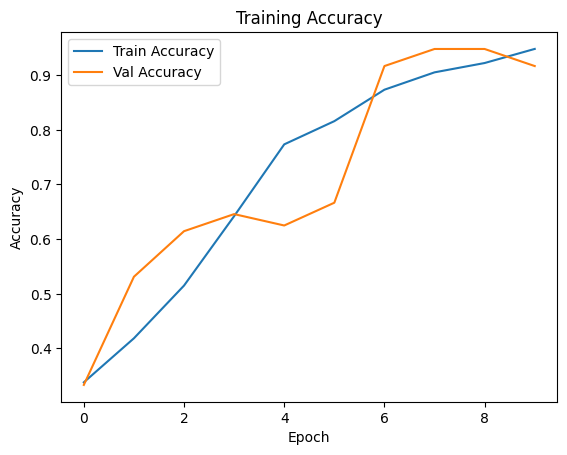

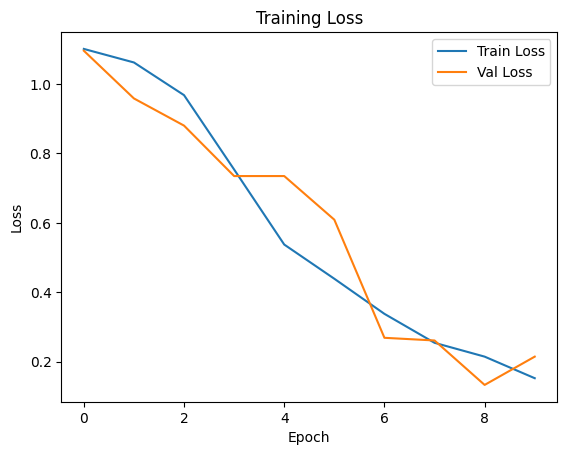

In [12]:


# Accuracy 曲線
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

# Loss 曲線
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


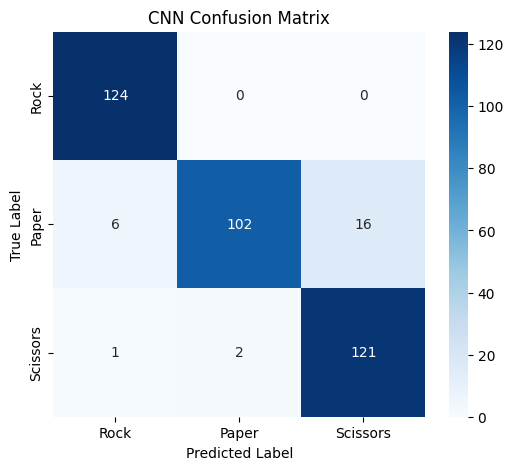

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 取得所有預測與真實標籤
y_true = []
y_pred = []

for images, labels in test_ds.unbatch():  # 移除 batch 維度
    img = tf.expand_dims(images, axis=0)  # 加 batch 維度
    pred = model.predict(img, verbose=0)
    pred_label = np.argmax(pred, axis=1)[0]
    y_pred.append(pred_label)
    y_true.append(labels.numpy())

# 計算混淆矩陣
cm = confusion_matrix(y_true, y_pred)
labels = ['Rock', 'Paper', 'Scissors']

# 畫出混淆矩陣
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN Confusion Matrix')
plt.show()


In [14]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=labels))


              precision    recall  f1-score   support

        Rock       0.95      1.00      0.97       124
       Paper       0.98      0.82      0.89       124
    Scissors       0.88      0.98      0.93       124

    accuracy                           0.93       372
   macro avg       0.94      0.93      0.93       372
weighted avg       0.94      0.93      0.93       372



# VGG16

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

In [16]:
IMG_SIZE = 150  # 與前面一致
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 1. 載入 VGG16 模型（不含分類頭）
base_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False
# 2. 建立自己的分類頭
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 類：Rock, Paper, Scissors
])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,867 (64.14 MB)

 Trainable params: 9,177,603 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
# 5. 訓練模型
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 50s 398ms/step - accuracy: 0.8185 - loss: 0.4019 - val_accuracy: 0.9919 - val_loss: 0.0245 - learning_rate: 1.0000e-04
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 234ms/step - accuracy: 0.9979 - loss: 0.0070 - val_accuracy: 0.9812 - val_loss: 0.0613 - learning_rate: 1.0000e-04
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 270ms/step - accuracy: 1.0000 - loss: 5.0731e-04 - val_accuracy: 0.9946 - val_loss: 0.0170 - learning_rate: 1.0000e-04
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 234ms/step - accuracy: 1.0000 - loss: 8.1222e-05 - val_accuracy: 0.9946 - val_loss: 0.0192 - learning_rate: 1.0000e-04
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 234ms/step - accuracy: 1.0000 - loss: 4.8506e-05 - val_accuracy: 1.0000 - val_loss: 0.0038 - learning_rate: 1.0000e-04
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 266ms/step - accuracy: 1.0000 - loss: 7.2556e-05 - val_accuracy: 1.0000 - val_loss: 0.0021 - learning_rate: 1.0000e-04
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 

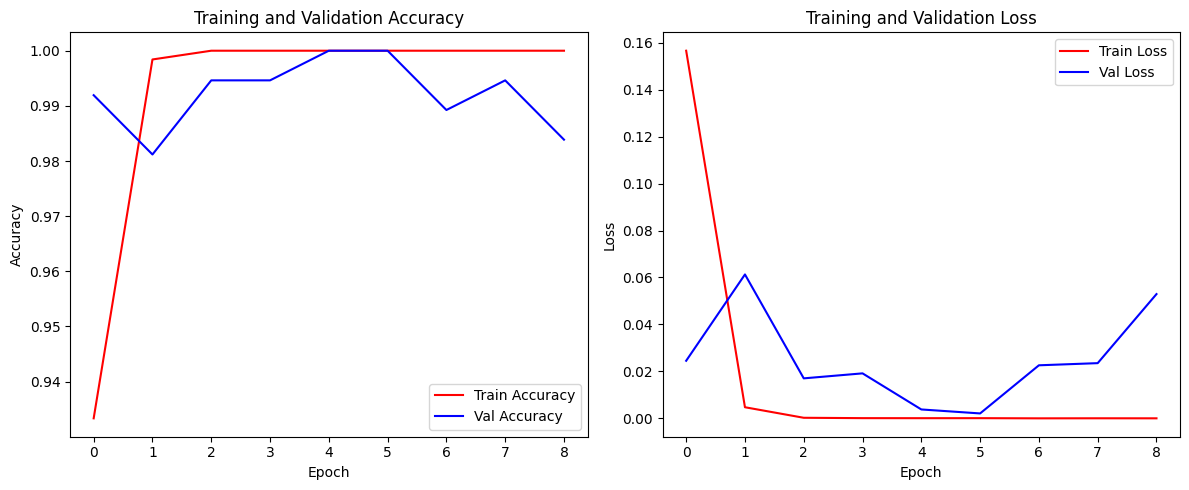

In [19]:

# --- 1️⃣ 繪製 Accuracy 與 Loss 曲線 ---
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Train Loss')
    plt.plot(epochs, val_loss, 'b', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


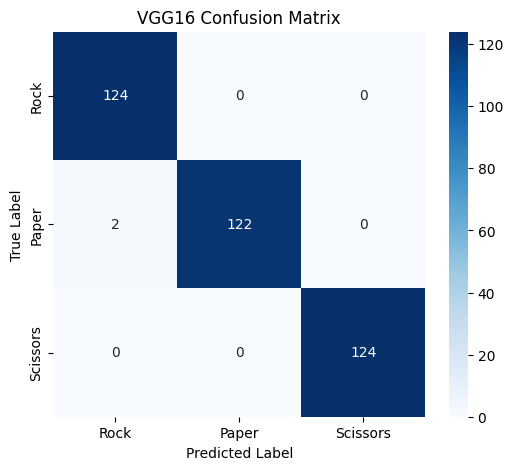


Classification Report:

              precision    recall  f1-score   support

        Rock       0.98      1.00      0.99       124
       Paper       1.00      0.98      0.99       124
    Scissors       1.00      1.00      1.00       124

    accuracy                           0.99       372
   macro avg       0.99      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



In [20]:
# --- 2️⃣ 混淆矩陣與 F1-score 評估 ---

# 收集真實與預測標籤
y_true = []
y_pred = []

for image_batch, label_batch in test_ds.unbatch():
    image = tf.expand_dims(image_batch, axis=0)  # 增加 batch 維度
    pred = model.predict(image, verbose=0)
    pred_label = np.argmax(pred, axis=1)[0]
    y_pred.append(pred_label)
    y_true.append(label_batch.numpy())

# 標籤名稱
class_names = ['Rock', 'Paper', 'Scissors']

# 混淆矩陣
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('VGG16 Confusion Matrix')
plt.show()

# classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


# Plotting Loss and Accuracy

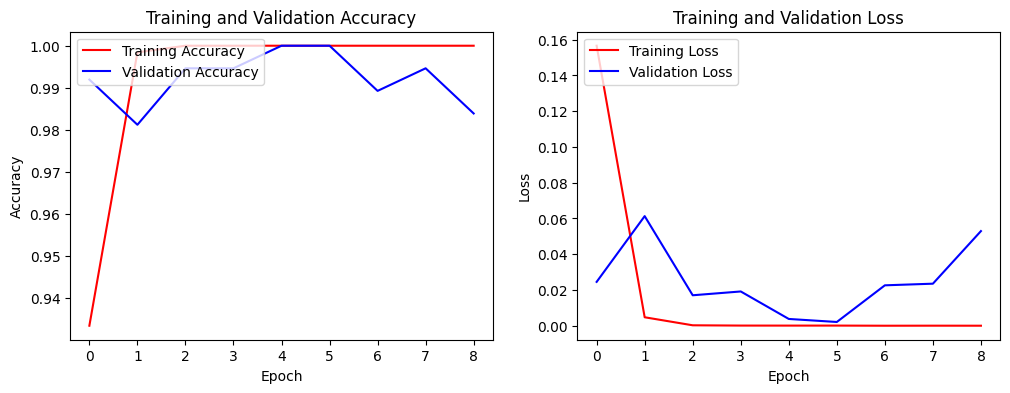

In [21]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12,4)

# Define accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Define loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plotting accuracy
ax[0].plot(epochs, acc, 'r', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='upper left')

# Plotting loss
ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper left')

plt.show()

# Model Prediction

In [39]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['Paper', 'Rock', 'Scissors']
  df['Product'] = prod
  df = df[['Product', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_product = 'Paper'
  elif predict_label == 1:
      predict_product = 'Rock'
  else:
      predict_product = 'Scissor'

  return predict_product, df

Saving scissors-hires1.png to scissors-hires1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step




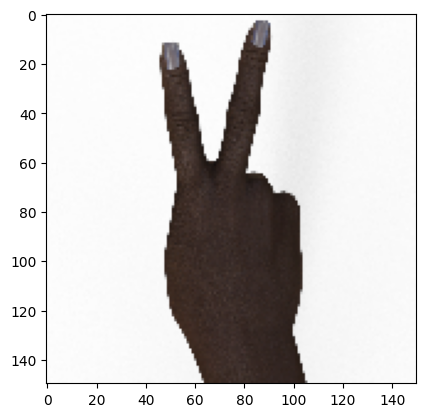


The image is detected as Scissor


    Product   Probability
0     Paper  1.477828e-11
1      Rock  2.595846e-12
2  Scissors  1.000000e+00




In [41]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')